## Question 1

N0, N1  60 40
***** plot *****


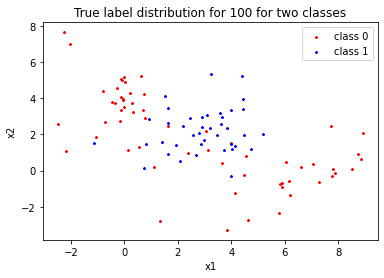

N0, N1  600 400
***** plot *****


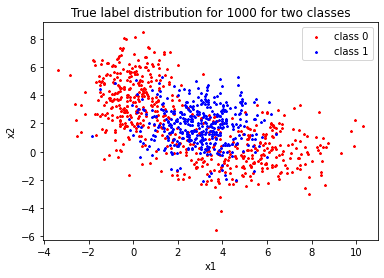

N0, N1  6000 4000
***** plot *****


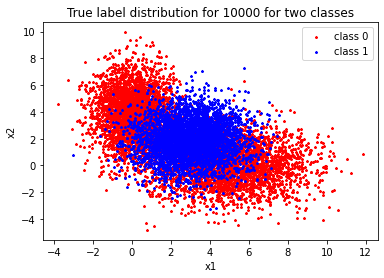

N0, N1  12000 8000
***** plot *****


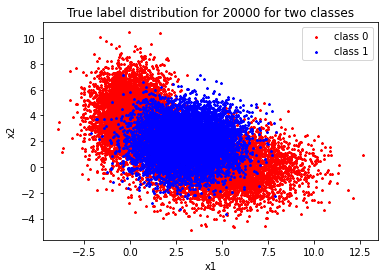

Part3
**********************************
train:  D100  val: D20k
training.. 
training completed!
w_trained  [-1.08685101  0.10815623  0.18539128]
acc  0.57935


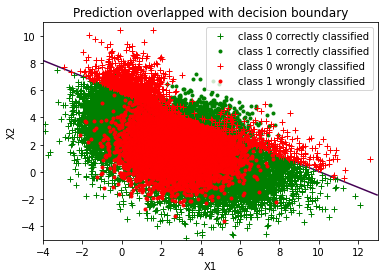

training.. 
training completed!
w_trained  [ 0.13373956  0.71176444 -0.26254435 -0.26954564  0.58280784 -0.17228202]
acc  0.81615


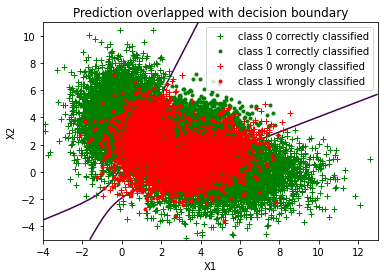

**********************************
**********************************
train:  D1k  val: D20k
training.. 
training completed!
w_trained  [-0.80829299  0.11295729  0.05106051]
acc  0.5628


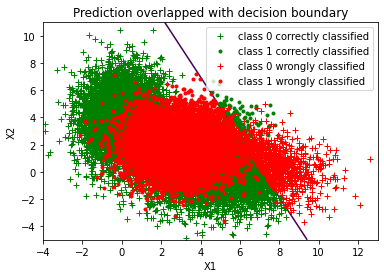

training.. 
training completed!
w_trained  [-1.3328232   1.51644423  0.2825428  -0.29618741  0.20363728 -0.15274456]
acc  0.818


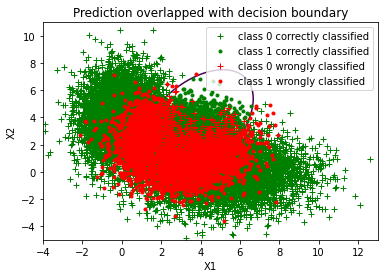

**********************************
**********************************
train:  D10k  val: D20k
training.. 
training completed!
w_trained  [-0.84112413  0.10906644  0.06740911]
acc  0.57525


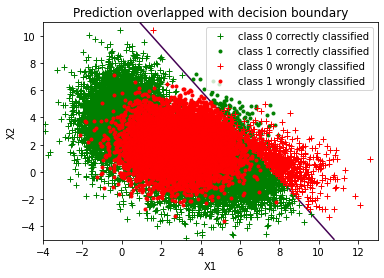

training.. 
training completed!
w_trained  [-0.73419944  1.16454276  0.01450949 -0.25960798  0.29755406 -0.14585008]
acc  0.8203


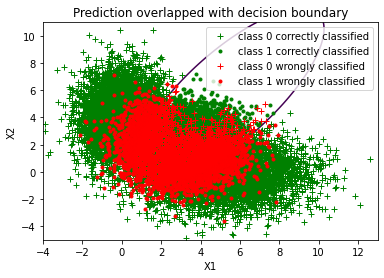

**********************************


In [ ]:
from google.colab import files
import numpy as np
import scipy.stats
import random
import matplotlib.pyplot as plt
import sys
from sklearn.mixture import GaussianMixture
from scipy.optimize import minimize
from matplotlib.colors import LogNorm
np.set_printoptions(suppress=True)

def calc_pxl(data, mean, cov):

    return scipy.stats.multivariate_normal.pdf(data, mean=mean, cov=cov)

def calc_prob_threshs(sample_type, log_score, log_thresh_range):

    tps, tns, fps, fns, fs = [], [], [], [], []

    num_samples = sample_type[0]
    N0, N1 = sample_type[1]
    data_wt_labels = sample_type[2]
    labels = data_wt_labels[2,:]

    for log_thresh in log_thresh_range:

        tp, tn, fp, fn, f = calc_prob_thresh(log_score, log_thresh, labels, N0, N1)
        tps.append(tp); fps.append(fp)
        tns.append(tn); fns.append(fn)
        fs.append(f)

    tps = np.array(tps); tns = np.array(tns)
    fps = np.array(fps); fns = np.array(fns)
    fs = np.array(fs)
    
    sample_type[3] = [tps, tns, fps, fns, fs]

    return sample_type

def calc_prob_thresh(log_score, log_thresh, labels, N0, N1):

    decisions = (log_score>log_thresh).astype('int')
    #print('decisions ',decisions)

    tp = np.sum(np.multiply(labels == 1, decisions==1).astype('int'))/N1
    fp = np.sum(np.multiply(labels == 0, decisions==1).astype('int'))/N0
    tn = np.sum(np.multiply(labels == 0, decisions==0).astype('int'))/N0
    fn = np.sum(np.multiply(labels == 1, decisions==0).astype('int'))/N1
    f = (fp*N0 + fn*N1)/(N0 + N1)

    return tp, tn, fp, fn, f

def erm(sample_type, means, covs):

    #data_wt_labels (3, N)
    print('***** erm *****')
    m0, m1 = means
    C0, C1 = covs

    data_wt_labels = sample_type[2]
    pts = data_wt_labels[:2,:].T ##(N, 2)
    labels = data_wt_labels[2,:]

    px0_0 = scipy.stats.multivariate_normal.pdf(pts, mean=m0[0,:], cov=C0[0,:,:])
    px0_1 = scipy.stats.multivariate_normal.pdf(pts, mean=m0[1,:], cov=C0[1,:,:])

    px0 = w1*px0_0 + w2*px0_1 ##(N, 1)
    px1 = scipy.stats.multivariate_normal.pdf(pts, mean=m1, cov=C1) ##(N, 1)

    score = np.divide(px1, px0)
    log_score = np.log(score)
    sort_log_score = np.sort(log_score)  ##(N, 1)
    
    eps = 1e-3
    log_thresh_range = np.append(sort_log_score[0] - eps, sort_log_score + eps)
    sample_type = calc_prob_threshs(sample_type, log_score, log_thresh_range)

    # theoretical
    log_thresh_t = np.log(pL[0]/pL[1])
    N0, N1 = sample_type[1]
    tp_t, tn_t, fp_t, fn_t, f_t = calc_prob_thresh(log_score, log_thresh_t, labels, N0, N1)

    # min PE thresh from data
    tps, tns, fps, fns, fs = sample_type[3]
    min_poe = np.min(fs)
    min_poe_ids = np.where(fs==min_poe)[0]
    
    # get closest thresh to theoretical
    min_dist, min_id = sys.maxsize, 0
    for id in min_poe_ids:
        dist = log_thresh_range[id] - log_thresh_t
        if dist<min_dist:
            min_dist = dist
            min_id = id

    print('min_poe_t ',f_t)
    print('min_poe_a ',fs[min_id])
    print('min_poe_thresh ',np.exp(log_thresh_range[min_id]))
    print('thresh_t ',np.exp(log_thresh_t))

    #ROC curve
    plt.plot(fps, tps, label='ROC Curve')
    plt.plot(fps[min_id], tps[min_id], 'ro', label='Estimated Minimum Error')
    plt.plot(fp_t, tp_t, 'g+', label='Theoretical Minimum Error')
    plt.title('Minimum Expected Risk ROC Curve')
    plt.xlabel('Prob. False positives')
    plt.ylabel('Prob. True positives')
    plt.legend()
    plt.show()

    # Probability of Error
    plt.plot(log_thresh_range, fs, label='Probability of Error')
    plt.plot(log_thresh_range[min_id], fs[min_id], 'ro', label='Estimated Minimum Error threshold')
    plt.plot(log_thresh_t, f_t, 'g+', label='Theoretical Threshold')
    plt.title('Probability of Error vs log_threshold')
    plt.xlabel('log_threshold')
    plt.ylabel('Probability of Error')
    plt.legend()
    plt.show()
    
    # Decision boundary
    log_score = np.log(score)
    decisions = (log_score>log_thresh_t).astype('int')
    pts = pts.T
    plot_boundary(pts, labels, decisions)
    hgrid = np.linspace(np.floor(min(pts[0,:])),np.ceil(max(pts[0,:])),100)
    vgrid = np.linspace(np.floor(min(pts[1,:])),np.ceil(max(pts[1,:])),100)
    dsg = np.zeros((100,100))
    mat = np.array(np.meshgrid(hgrid, vgrid))

    for i in range(100):
        for j in range(100):
            px0_0 = scipy.stats.multivariate_normal.pdf(np.array([mat[0][i][j], mat[1][i][j]]), mean=m0[0,:], cov=C0[0,:,:])
            px0_1 = scipy.stats.multivariate_normal.pdf(np.array([mat[0][i][j], mat[1][i][j]]), mean=m0[1,:], cov=C0[1,:,:])
            px0 = w1*px0_0 + w2*px0_1 ##(N, 1)
            px1 = scipy.stats.multivariate_normal.pdf(np.array([mat[0][i][j], mat[1][i][j]]), mean=m1, cov=C1) ##(N, 1)
            dsg[i][j] = np.log(px0) - np.log(px1) - np.log(pL[0]/pL[1])

    plt.contour(mat[0], mat[1], dsg)
    plt.show()

def split_data(data_wt_labels):

    l0_ids = np.where(data_wt_labels[2,:]==0)[0]
    l1_ids = np.where(data_wt_labels[2,:]==1)[0]

    data0 = data_wt_labels[:,l0_ids]
    data1 = data_wt_labels[:,l1_ids]

    return data0, data1

def print_gmm_params(gmm_l0, gmm_l1):

    print('GMM params L0 ',gmm_l0.get_params())
    print('GMM params L1 ',gmm_l1.get_params())

    if gmm_l0.converged_:print('Label 0 converged')
    else:print('Label 0 not converged')

    if gmm_l1.converged_:print('Label 1 converged')
    else:print('Label 1 not converged')

    print('Label 0 weights ',gmm_l0.weights_, gmm_l0.weights_.shape)
    print('Label 1 weights ',gmm_l1.weights_, gmm_l1.weights_.shape)

    print('Label 0 means ',gmm_l0.means_.shape)
    print('Label 0 covariances ',gmm_l0.covariances_.shape)

    print('Label 1 means ',gmm_l1.means_.shape)
    print('Label 1 covariances ',gmm_l1.covariances_.shape)


def mle_gmm(train_sample_type, val_sample_type):

    data_wt_labels = train_sample_type[2]
    data0, data1 = split_data(data_wt_labels)
    data0, data1 = data0[:2, :].T, data1[:2, :].T

    gmm_l0 = GaussianMixture(2, covariance_type='full', 
                     random_state=0).fit(data0)

    gmm_l1 = GaussianMixture(1, covariance_type='full', 
                     random_state=0).fit(data1)

    #print_gmm_params(gmm_l0, gmm_l1)

    m01 = gmm_l0.means_[0,:]
    m02 = gmm_l0.means_[1,:]
    C01 = gmm_l0.covariances_[0,:]
    C02 = gmm_l0.covariances_[1,:]
    gmm_weights0 = gmm_l0.weights_

    w1 = gmm_weights0[0]; w2 = gmm_weights0[1]

    m1 = gmm_l1.means_[0,:]
    C1 = gmm_l1.covariances_[0,:]
    gmm_weights1 = gmm_l1.weights_

    print('C01: ', C01)
    print('C02: ', C02)
    print('C1: ', C1)

    print('m01: ', m01)
    print('m02: ', m02)
    print('m1: ', m1)

    print('w1 ',w1)
    print('w2 ',w2)

    data_wt_labels = val_sample_type[2]
    pts = data_wt_labels[:2,:].T ##(N, 2)
    labels = data_wt_labels[2,:]

    px0_0 = scipy.stats.multivariate_normal.pdf(pts, mean=m01, cov=C01)
    px0_1 = scipy.stats.multivariate_normal.pdf(pts, mean=m02, cov=C02)

    px0 = w1*px0_0 + w2*px0_1 ##(N, 1)
    px1 = scipy.stats.multivariate_normal.pdf(pts, mean=m1, cov=C1) ##(N, 1)

    score = np.divide(px1, px0)
    log_score = np.log(score)
    sort_log_score = np.sort(log_score)  ##(N, 1)
    
    eps = 1e-3
    log_thresh_range = np.append(sort_log_score[0] - eps, sort_log_score + eps)
    val_sample_type = calc_prob_threshs(val_sample_type, log_score, log_thresh_range)

    # theoretical
    log_thresh_t = np.log(pL[0]/pL[1])
    N0, N1 = val_sample_type[1]
    tp_t, tn_t, fp_t, fn_t, f_t = calc_prob_thresh(log_score, log_thresh_t, labels, N0, N1)

    # min PE thresh from data
    tps, tns, fps, fns, fs = val_sample_type[3]
    min_poe = np.min(fs)
    min_poe_ids = np.where(fs==min_poe)[0]
    
    # get closest thresh to theoretical
    min_dist, min_id = sys.maxsize, 0
    for id in min_poe_ids:
        dist = log_thresh_range[id] - log_thresh_t
        if dist<min_dist:
            min_dist = dist
            min_id = id

    print('min_poe_t ',f_t)
    print('min_poe_a ',fs[min_id])
    print('min_poe_thresh ',np.exp(log_thresh_range[min_id]))
    print('thresh_t ',np.exp(log_thresh_t))

    #ROC curve
    plt.plot(fps, tps, label='ROC Curve')
    plt.plot(fps[min_id], tps[min_id], 'ro', label='Estimated Minimum Error Threshold')
    plt.plot(fp_t, tp_t, 'g+', label='Theoretical Minimum Error')
    plt.title('ROC Curve')
    plt.xlabel('Prob. False positives')
    plt.ylabel('Prob. True positives')
    plt.legend()
    plt.show()

    # Probability of Error
    plt.plot(log_thresh_range, fs, label='Probability of Error')
    plt.plot(log_thresh_range[min_id], fs[min_id], 'ro', label='Estimated Minimum Error threshold')
    plt.plot(log_thresh_t, f_t, 'g+', label='Theoretical Threshold')
    plt.title('Probability of Error vs log_threshold')
    plt.xlabel('log_threshold')
    plt.ylabel('Probability of Error')
    plt.legend()
    plt.show()

    # GMM contour for Class 0
    data_wt_labels = train_sample_type[2]
    pts = data_wt_labels[:2,:] ##(2, N)
    hgrid = np.linspace(np.floor(min(pts[0,:])),np.ceil(max(pts[0,:])),100)
    vgrid = np.linspace(np.floor(min(pts[1,:])),np.ceil(max(pts[1,:])),100)
    dsg = np.zeros((100,100))
    mat = np.array(np.meshgrid(hgrid, vgrid))

    for i in range(100):
        for j in range(100):
            px0_0 = scipy.stats.multivariate_normal.pdf(np.array([mat[0][i][j], mat[1][i][j]]), mean=m0[0,:], cov=C0[0,:,:])
            px0_1 = scipy.stats.multivariate_normal.pdf(np.array([mat[0][i][j], mat[1][i][j]]), mean=m0[1,:], cov=C0[1,:,:])
            dsg[i][j] = w1*px0_0 + w2*px0_1 ##(N, 1)

    CS = plt.contour(mat[0], mat[1], dsg)
    CB = plt.colorbar(CS, shrink=0.8, extend='both')
    plt.scatter(pts[0,:], pts[1,:], .8)
    plt.title('Contour Plot for Class 0 Estimated GMM for ' + str(pts.shape[1]) + 'samples')
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.show()

def calc_cost(x, data, labels):

    w = x

    h = 1 / (1+ np.exp(-(np.dot(w.T,data)))) ##(N, )
    loss = labels * np.log(h) + (1 - labels) * np.log(1 - h)  ##(N, )

    sum = np.sum(loss)
    scale = -(1.0 / data.shape[1]) 
    cost = scale * sum
    
    return cost

def predict(w, data, thresh=0.5):

    h = 1 / (1+ np.exp(-(np.dot(w.T,data))))

    h[h>=thresh] = 1
    h[h<thresh] = 0

    return h

def mle_opt_lin(train_sample_type, test_sample_type):

    train_data_wt_labels = train_sample_type[2]
    train_data = train_data_wt_labels[:2, :]
    train_labels = train_data_wt_labels[2,:]
    train_ones = np.ones(train_data_wt_labels.shape[1]).reshape((1, -1))
    train_data = np.concatenate((train_ones, train_data), axis=0)  ##(3, N)

    print('training.. ')
    w_init = np.zeros((3, 1), dtype='float')
    result = minimize(calc_cost, w_init, args=(train_data, train_labels))
    w_trained = result.x
    print('training completed!')

    print('w_trained ',w_trained)
    test_data_wt_labels = test_sample_type[2]
    test_data = test_data_wt_labels[:2, :]
    test_labels = test_data_wt_labels[2,:]
    test_ones = np.ones(test_data_wt_labels.shape[1]).reshape((1, -1))
    test_data = np.concatenate((test_ones, test_data), axis=0)  ##(3, N)

    decisions = predict(w_trained, test_data)
    acc = calc_poe(decisions, test_labels)
    print('acc ',acc)

    plot_boundary(test_data_wt_labels[:2, :], test_labels, decisions)
    mat = get_mesh_grid(test_data_wt_labels[:2, :])
    boundary = np.zeros((100, 100))
    for i in range(100):
        for j in range(100):
            x1 = mat[0][i][j]
            x2 = mat[1][i][j]
            z = np.c_[1, x1, x2].T
            boundary[i][j] = np.sum(np.dot(w_trained.T, z))
    plt.contour(mat[0], mat[1], boundary, levels = [0])
    plt.show()

def gen_quad_data(data_wt_labels):

    num_samples = data_wt_labels.shape[1]
    input_data = data_wt_labels[:2, :] # (x1, x2)
    data = np.zeros((6, num_samples), dtype='float') # (1, x1, x2, x1**2, x1x2, x2**2)

    data[0] = np.ones(num_samples).reshape((1, -1)) # 1
    data[1:3] = input_data #x1, x2
    data[3] = np.square(input_data[0, :]) # x1**2
    data[4] = np.multiply(input_data[0, :], input_data[1, :]) # x1x2
    data[5] = np.square(input_data[1, :]) # x2**2
    
    return data

def mle_opt_quad(train_sample_type, test_sample_type):

    train_data_wt_labels = train_sample_type[2]
    train_labels = train_data_wt_labels[2,:]
    train_data = gen_quad_data(train_data_wt_labels)

    print('training.. ')
    w_init = np.zeros((6, 1), dtype='float')
    result = minimize(calc_cost, w_init, args=(train_data, train_labels))
    w_trained = result.x
    print('training completed!')

    print('w_trained ',w_trained)
    test_data_wt_labels = test_sample_type[2]
    test_data = gen_quad_data(test_data_wt_labels)
    test_labels = test_data_wt_labels[2,:]

    decisions = predict(w_trained, test_data)
    acc = calc_poe(decisions, test_labels)
    print('acc ',acc)

    plot_boundary(test_data_wt_labels[:2, :], test_labels, decisions)
    mat = get_mesh_grid(test_data_wt_labels[:2, :])
    boundary = np.zeros((100, 100))
    for i in range(100):
        for j in range(100):
            x1 = mat[0][i][j]
            x2 = mat[1][i][j]
            z = np.c_[1, x1, x2, x1**2, x1*x2, x2**2].T
            boundary[i][j] = np.sum(np.dot(w_trained.T, z))
    plt.contour(mat[0], mat[1], boundary, levels = [0])
    plt.show()

def calc_poe(decisions, labels):

    N0 = np.sum((labels == 0).astype('int'))
    N1 = np.sum((labels == 1).astype('int'))

    tp = np.sum(np.multiply(labels == 1, decisions==1).astype('int'))/N1
    fp = np.sum(np.multiply(labels == 0, decisions==1).astype('int'))/N0
    tn = np.sum(np.multiply(labels == 0, decisions==0).astype('int'))/N0
    fn = np.sum(np.multiply(labels == 1, decisions==0).astype('int'))/N1
    f = (fp*N0 + fn*N1)/(N0 + N1)

    return (tp*N1 + tn*N0)/(N0 + N1)

def mle_opt(train_sample_type, test_sample_type, part=1):

    if part==1:
        mle_opt_lin(train_sample_type, test_sample_type)
    else:
        mle_opt_quad(train_sample_type, test_sample_type)

def plot_boundary(data, labels, decisions):

    tp = np.multiply(labels == 1, decisions == 1).astype('int')
    tn = np.multiply(labels == 0, decisions == 0).astype('int')
    fp = np.multiply(labels == 0, decisions == 1).astype('int')
    fn = np.multiply(labels == 1, decisions == 0).astype('int')

    tp_ids = np.where(tp == 1)[0]
    tn_ids = np.where(tn == 1)[0]
    fp_ids = np.where(fp == 1)[0]
    fn_ids = np.where(fn == 1)[0]

    plt.plot(data[0, tn_ids], data[1, tn_ids], '+', color ='g', markersize = 6)
    plt.plot(data[0, tp_ids], data[1, tp_ids], '.', color ='g', markersize = 6)
    plt.plot(data[0, fp_ids], data[1, fp_ids], '+', color ='r', markersize = 6)
    plt.plot(data[0, fn_ids], data[1, fn_ids], '.', color ='r', markersize = 6)

    plt.legend(["class 0 correctly classified", 'class 1 correctly classified','class 0 wrongly classified', 'class 1 wrongly classified'])
    plt.title('Prediction overlapped with decision boundary')
    plt.xlabel("X1")
    plt.ylabel("X2")

def get_mesh_grid(data, num_grid=100):

    hgrid = np.linspace(np.floor(min(data[0,:])), np.ceil(max(data[0,:])), num_grid)
    vgrid = np.linspace(np.floor(min(data[1,:])), np.ceil(max(data[1,:])), num_grid)
    mat = np.array(np.meshgrid(hgrid, vgrid))

    return mat

def plot_dist(data, label_names):

    tname, xname, yname = label_names

    print('***** plot *****')
    data0, data1 = split_data(data)

    plt.scatter(data0[0, :], data0[1, :], s=5, color = 'red', label = 'class 0',marker='*')
    plt.scatter(data1[0, :], data1[1, :], s=5, color = 'blue', label = 'class 1', marker='*')

    plt.title(tname)
    plt.xlabel(xname)
    plt.ylabel(yname)
    plt.legend()
    plt.show()

def generate_data_pxgl(prior, means, covs, num_samples):

    m0, m1 = means
    C0, C1 = covs
    
    N0 = int(prior[0]*num_samples)
    N1 = num_samples - N0
    print('N0, N1 ',N0, N1)

    # generate L0
    N00 = int(w1*N0)
    N01 = N0 - N00
    wt_dist = [0]*N00 + [1]*N01
    for i in range(10):
        random.shuffle(wt_dist)
    wt_dist = np.array(wt_dist)

    dist0 = np.random.multivariate_normal(m0[0,:], C0[0,:,:], N0).T
    dist1 = np.random.multivariate_normal(m0[1,:], C0[1,:,:], N0).T
    pxgl0 = np.multiply(1-wt_dist, dist0) + np.multiply(wt_dist, dist1)

    # generate L1
    pxgl1 = np.random.multivariate_normal(m1, C1, N1).T

    ## combine data and label
    labels = [0]*N0 + [1]*N1
    labels = np.reshape(labels, (1, -1))

    pxgl = np.concatenate((pxgl0, pxgl1), axis=1)
    data = np.concatenate((pxgl, labels), axis=0)
    
    return data, N0, N1

def generate_data_pxgl_samples(samples_type):

    for i, key in enumerate(samples_type):

        sample_type = samples_type[key]
        num_samples = int(sample_type[0][0])

        data_wt_labels, N0, N1 = generate_data_pxgl(pL, [m0, m1], [C0, C1], num_samples)

        sample_type[1] = [N0, N1]
        sample_type[2] = data_wt_labels

        label_names = ["True label distribution for " + str(num_samples) + " for two classes", "x1", "x2"]
        plot_dist(data_wt_labels, label_names)

    return samples_type

if __name__ == "__main__":

    dims = 2 #No. of dimensions/features

    #priors
    pL = [0.6, 0.4]
    
    #means
    size_m0 = 2
    size_C0 = size_m0
    m0 = np.zeros((size_m0,dims))
    m0[0,:] = np.array([5, 0])
    m0[1,:] = np.array([0,4]) 
    m1 = [3, 2]

    #covariance
    C0 = np.zeros((size_C0,dims,dims), dtype=int)
    C0[0,:,:] = np.array([[4, 0], [0, 2]])
    C0[1,:,:] = np.array([[1, 0], [0, 3]])
    C1 = np.array([[2, 0], [0, 2]])

    ## gaus weight
    w1 = 0.5; w2 = 0.5

    # data
    ## num_samples, [N0, N1], data_wt_labels, [tps, tns, fps, fns, fs]
    samples_type = {\
        'D100': [[100], [], [], []], \
        'D1k': [[1000], [], [], []], \
        'D10k': [[10000], [], [], []], \
        'D20k': [[20000], [], [], []], \
    }    

    ## generate data for all samples
    samples_type = generate_data_pxgl_samples(samples_type)

    erm_ = 0
    gmm_ = 0
    opt_ = 1

    ## erm
    if erm_:
        print('Part1')
        erm(samples_type['D20k'], [m0, m1], [C0, C1])

    ## mle_gmm
    if gmm_:
        print('Part2')
        for i, key in enumerate(list(samples_type.keys())[:-1]):

            print('**********************************')
            print('train: ',key,' val: D20k')
            mle_gmm(samples_type[key], samples_type['D20k'])
            print('**********************************')

            # if i==0:break

    if opt_:
        print('Part3')
        for i, key in enumerate(list(samples_type.keys())[:-1]):

            print('**********************************')
            print('train: ',key,' val: D20k')
            mle_opt(samples_type[key], samples_type['D20k'], part=1)
            mle_opt(samples_type[key], samples_type['D20k'], part=2)
            print('**********************************')


# Question 2

measurements  [1.64866192]
r i  1.6486619161491989


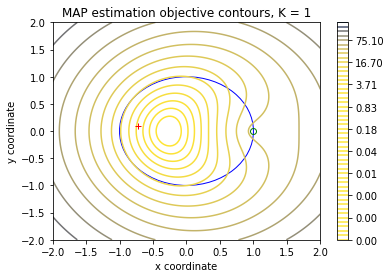

measurements  [1.59264371 0.02270309]
r i  1.5926437062478822
r i  0.022703090619810018


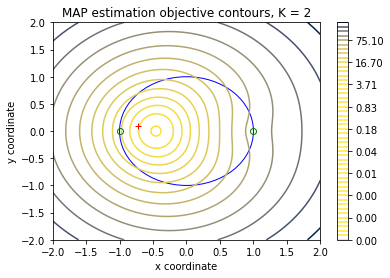

measurements  [1.28849457 1.05432908 1.13724284]
r i  1.2884945696386063
r i  1.0543290764306827
r i  1.13724284057075


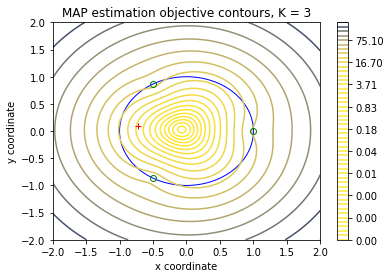

measurements  [1.40818826 0.88258047 0.08484576 1.14277397]
r i  1.4081882646814767
r i  0.8825804656108724
r i  0.08484575553129159
r i  1.1427739704343411


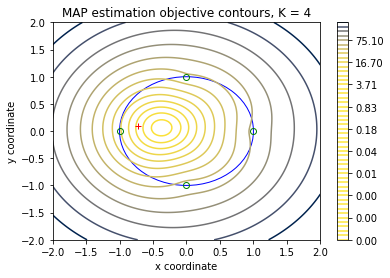

measurements  [1.96582219 1.41356432 1.04128359 0.86727561 0.77994797 0.89294359
 0.28330708 1.1078299  1.68313883 1.61124598]
r i  1.9658221942767788
r i  1.413564319534497
r i  1.0412835948441066
r i  0.8672756149060584
r i  0.7799479745871996
r i  0.8929435883575039
r i  0.2833070786485156
r i  1.107829899736695
r i  1.6831388291332088
r i  1.6112459811102655


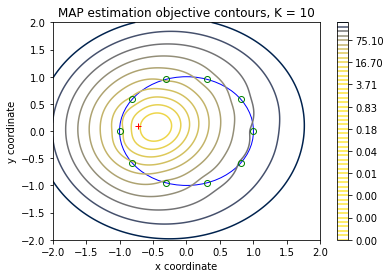

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

CONTOUR_LEVELS = np.geomspace(0.0001, 250, 50)

def get_true_pos(center, radius):

    rand_r = random.uniform(0.0, 1.0)
    rand_t = random.uniform(0.0, 1.0)
    r = radius * np.sqrt(rand_r)
    theta = 2 * np.pi * rand_t
    x = center[0] + r * np.cos(theta)
    y = center[1] + r * np.sin(theta)

    return np.array([x, y])

def get_equidist_points(center, radius, num_points):

    equ_pts = []
    for i in range(num_points):
        theta = 2.0 * np.pi * i/ num_points
        x = center[0] + radius * np.cos(theta)
        y = center[1] + radius * np.sin(theta)
        equ_pts.append([x, y])
    
    return np.array(equ_pts)

def get_measurements(equ_pts, true_pos):

    measurements = []
    for equ_pt in equ_pts:

        dist = np.linalg.norm(true_pos - equ_pt)
        measurement = dist + np.random.normal(0, sigi)

        while measurement<=0:
            measurement = dist + np.random.normal(0, sigi)

        measurements.append(measurement)

    return np.array(measurements)

def get_MAP_contour(equ_pts, measurements, quad_range, num_grid_pts):

    min_, max_ = quad_range[0], quad_range[1]
    xgrid = np.linspace(min_, max_, num_grid_pts)
    ygrid = np.linspace(min_, max_, num_grid_pts)
    mat = np.array(np.meshgrid(xgrid, ygrid))

    contours = np.zeros((num_grid_pts, num_grid_pts), dtype='float')
    for i in range(num_grid_pts):
        for j in range(num_grid_pts):
            x1 = mat[0][i][j]
            x2 = mat[1][i][j]
            pt = np.array([x1, x2])
            contours[i][j] = get_MAP_obj(pt, equ_pts, measurements, num_pts)
    
    return contours, mat

def plot_equilevel_contours(equ_pts, measurements, quad_range, num_grid_pts):

    contours, grid = get_MAP_contour(equ_pts, measurements, quad_range, num_grid_pts)

    ax = plt.gca()

    unit_circle = plt.Circle((0, 0), 1, color='blue', fill=False)
    ax.add_artist(unit_circle)

    plt.contour(grid[0], grid[1], contours, cmap='cividis_r', levels=CONTOUR_LEVELS)

    for (pt_i, r_i) in zip(equ_pts, measurements):
        
        print('r i ',r_i)
        x, y = pt_i[0], pt_i[1]
        plt.plot((x), (y), 'o', color='g', markerfacecolor='none')
        # range_circle = plt.Circle((x, y), r_i, color='g', fill=False)
        # ax.add_artist(range_circle)

    ax.set_xlabel("x coordinate")
    ax.set_ylabel("y coordinate")
    ax.set_title("MAP estimation objective contours, K = " + str(len(measurements)))

    ax.set_xlim((-2, 2))
    ax.set_ylim((-2, 2))
    ax.plot([true_pos[0]], [true_pos[1]], '+', color='r')
    plt.colorbar();
    plt.show()
    
def get_MAP_obj(pt, equ_pts, measurements, num_pts): ##(1, 2)

    sigma_mat = np.array([[sigx**2, 0], [0, sigy**2]])

    prior = np.matmul(pt, np.linalg.inv(sigma_mat))
    prior = np.matmul(prior, pt.T)

    measure_sum = 0
    for equ_pt, r_i in zip(equ_pts, measurements):
        d_i = np.linalg.norm(pt - equ_pt)
        measure = (r_i - d_i)**2/sigi**2
        measure_sum += measure

    return prior + measure_sum

if __name__ == "__main__":

    sigx, sigy = 0.25, 0.25
    sigi = 0.3
    num_points = [1,2,3,4,10]
    center = [0, 0]
    radius = 1
    quad_range = (-2, 2)
    num_grid_pts = 128

    true_pos = get_true_pos(center, radius)

    for num_pts in num_points:
        equ_pts = get_equidist_points(center, radius, num_pts)
        measurements = get_measurements(equ_pts, true_pos)
        print('measurements ',measurements)
        plot_equilevel_contours(equ_pts, measurements, quad_range, num_grid_pts)
